Epoch 1, Training Loss: 0.6833, Validation Error: 0.2889
Epoch 26, Training Loss: 0.6465, Validation Error: 0.5556
Epoch 51, Training Loss: 0.5678, Validation Error: 0.7111
Epoch 76, Training Loss: 0.5726, Validation Error: 0.7111
Epoch 101, Training Loss: 0.5620, Validation Error: 0.7111
Epoch 126, Training Loss: 0.5261, Validation Error: 0.7111
Training Metrics - Accuracy: 0.7481, Precision: 0.7816, Recall: 0.8193, F1 Score: 0.8000
Confusion Matrix for Training Data


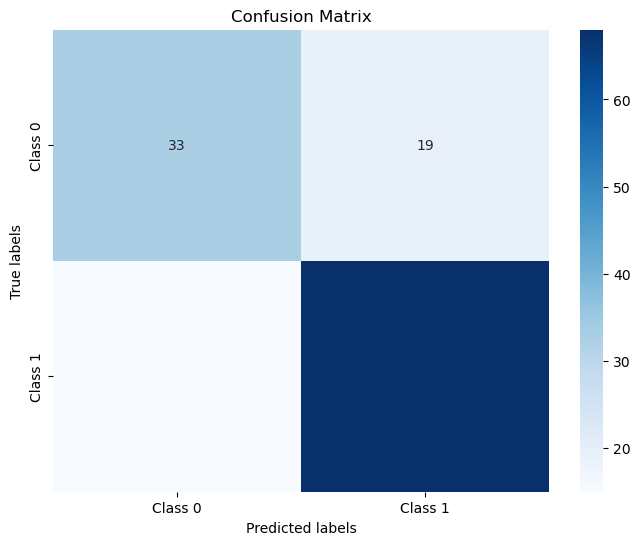

Test Metrics - Accuracy: 0.2889, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Confusion Matrix for Test Data


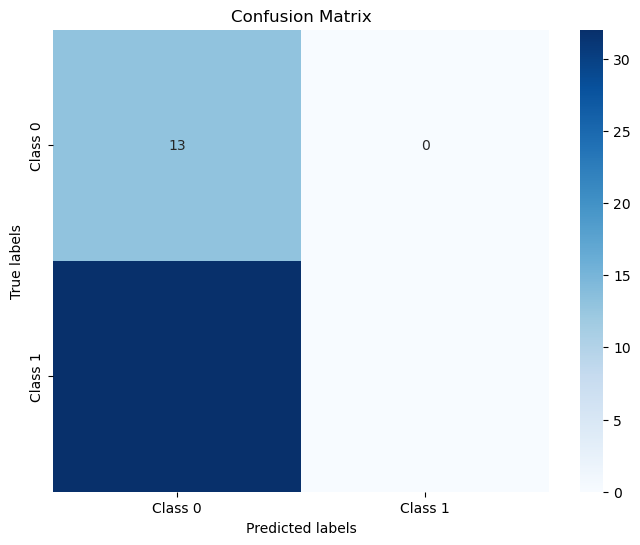

Epoch 1, Training Loss: 0.6786, Validation Error: 0.3000
Epoch 26, Training Loss: 0.5813, Validation Error: 0.3000
Epoch 51, Training Loss: 0.4891, Validation Error: 0.3000
Epoch 76, Training Loss: 0.4016, Validation Error: 0.5000
Epoch 101, Training Loss: 0.3669, Validation Error: 0.5000
Epoch 126, Training Loss: 0.3524, Validation Error: 0.5000

Avg cross-validation metrics for fold 1: Accuracy: 50.00%, Precision: 1.0000, Recall: 0.2857, F1 Score: 0.4444


Avg cross-validation accuracy for fold 1: 50.0% 

Epoch 1, Training Loss: 0.7150, Validation Error: 0.6000
Epoch 26, Training Loss: 0.6044, Validation Error: 0.4000
Epoch 51, Training Loss: 0.5793, Validation Error: 0.4000
Epoch 76, Training Loss: 0.5035, Validation Error: 0.4000
Epoch 101, Training Loss: 0.4426, Validation Error: 0.4000
Epoch 126, Training Loss: 0.4002, Validation Error: 0.4000

Avg cross-validation metrics for fold 2: Accuracy: 55.00%, Precision: 0.5789, Recall: 0.9167, F1 Score: 0.7097


Avg cross-validation acc

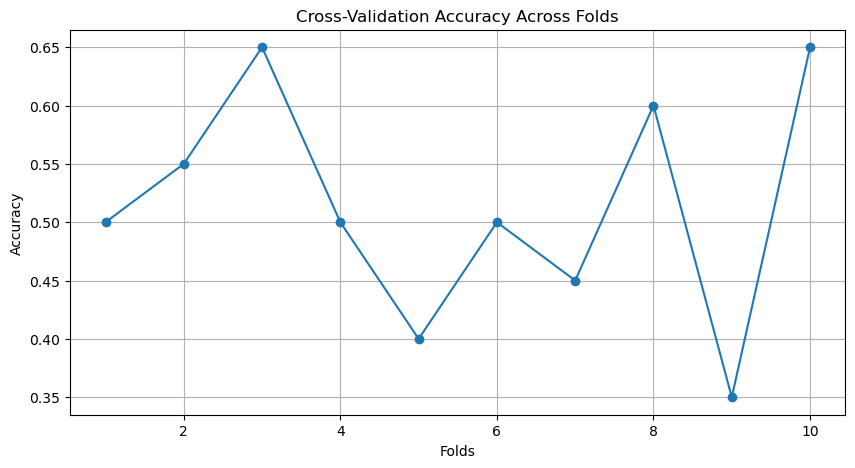

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

from collections import Counter

# Initialize the Tkinter root window
root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()

# Normalize data and assign movement direction values
def prep(dataset):
    scaler = StandardScaler()

    dataset['RSI (14D)'] = ta.rsi(dataset['Close'], length=14)
    dataset['20 Day CCI'] = ta.cci(high=dataset['High'], low=dataset['Low'], 
                                   close=dataset['Close'], length=20)
    dataset['Williams %R'] = ta.willr(high=dataset['High'], low=dataset['Low'], 
                                      close=dataset['Close'], length=14)
    dataset['EMA (5D)'] = dataset['Close'].ewm(span=5, adjust=False).mean()

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings']
    
    dataset[features] = dataset[features].astype(float)
    dataset[features] = scaler.fit_transform(dataset[features])

    dataset['MA10'] = dataset['Close'].rolling(window=10).mean()
    dataset['MA50'] = dataset['Close'].rolling(window=50).mean()
    
    dataset['Target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
    prepared_data = dataset.dropna()
    return prepared_data, scaler

# Define LSTM Model class
class LSTM_Model(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(LSTM_Model, self).__init__()
        self.hidden_layer = hidden_layer
        #self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_layer, hidden_layer, batch_first=True, bidirectional=False)
        self.linear_layer = nn.Linear(hidden_layer, output_layer)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer).cuda(),
                            torch.zeros(1,1,self.hidden_layer).cuda())

    def forward(self, input_tensor):
        self.hidden_cell = (torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda(), 
                            torch.zeros(1, input_tensor.size(0), self.hidden_layer).cuda())
        out, self.hidden_cell = self.lstm(input_tensor, self.hidden_cell)
        lstm_out_last = out[:, -1, :]
        predicted_values = self.linear_layer(lstm_out_last)
        return predicted_values

# Create sequences for input data and corresponding labels
def create_sequence(input_data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(input_data) - sequence_length):
        sequence = input_data[i : i + sequence_length, :-1]
        label = input_data[i + sequence_length, -1]
        sequences.append(sequence)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels

# Convert sequences and labels to PyTorch tensors
def convert_to_tensor(sequences, labels):
    # Convert sequences to tensors if they are not already
    if not isinstance(sequences[0], torch.Tensor):
        sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    
    # Convert labels to tensor and reshape
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    else:
        labels = labels.view(-1, 1)  # Ensure the correct shape if already a tensor

    # Pad sequences
    sequences = pad_sequence(sequences, batch_first=True)
    
    return sequences, labels

# Train the model with data provided
def trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda'):
    train_errors, val_errors = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for sequence, labels in train_data:
            opt.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer).to(device),
                                 torch.zeros(1, 1, model.hidden_layer).to(device))
            
            sequence = sequence.to(device)
            labels = labels.to(device)

            y = model(sequence)
            loss = loss_func(y, labels)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        # Compute average loss for the epoch
        train_errors.append(epoch_loss / len(train_data))

        # Validate the model
        val_metrics = evaluate_model(model, val_data, device)
        val_accuracy = val_metrics['accuracy']  # Extract accuracy
        val_errors.append(1 - val_accuracy)  # Convert accuracy to error

        # Print progress
        if epoch % 25 == 1:
            print(f'Epoch {epoch}, Training Loss: {epoch_loss / len(train_data):.4f}, Validation Error: {1 - val_accuracy:.4f}')
    
    return train_errors, val_errors

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    predictions, labels = [], []
    
    with torch.no_grad():
        for sequence, label in data_loader:
            sequence = sequence.float().to(device)
            output = model(sequence)
            pred = torch.round(torch.sigmoid(output)).cpu().numpy()
            predictions.extend(pred.flatten())
            labels.extend(label.numpy())
    
    # Convert lists to numpy arrays for sklearn metric functions
    predictions = np.array(predictions)
    labels = np.array(labels)

    

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    cm = confusion_matrix(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Time Series Cross-Validation
def time_series_cv(model_class, sequences, labels, n_splits, epochs, device='cuda'):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    i = 1

    for train_index, test_index in tscv.split(sequences):
        train_sequences, test_sequences = [sequences[i] for i in train_index], [sequences[i] for i in test_index]
        train_labels, test_labels = [labels[i] for i in train_index], [labels[i] for i in test_index]
        
        # Convert to tensors
        train_sequences, train_labels = convert_to_tensor(train_sequences, train_labels)
        test_sequences, test_labels = convert_to_tensor(test_sequences, test_labels)

        # Create dataLoaders
        train_data = torch.utils.data.DataLoader(list(zip(train_sequences, train_labels)), shuffle=True, batch_size=100)
        test_data = torch.utils.data.DataLoader(list(zip(test_sequences, test_labels)), shuffle=False, batch_size=100)
        
        # Initialize model
        model = model_class(input_layer=15, hidden_layer=50, output_layer=1).to(device)
        opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        loss_func = nn.BCEWithLogitsLoss()

        # Train and evaluate
        train_errors, val_errors = trainer(model, train_data, test_data, loss_func, opt, epochs, device)
        test_metrics = evaluate_model(model, test_data, device)
        
        accuracies.append(test_metrics['accuracy'])
        precisions.append(test_metrics['precision'])
        recalls.append(test_metrics['recall'])
        f1_scores.append(test_metrics['f1_score'])

        print(f'\nAvg cross-validation metrics for fold {i}: Accuracy: {accuracies[-1] * 100:.2f}%, '
              f'Precision: {precisions[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1 Score: {f1_scores[-1]:.4f}\n')

        print(f'\nAvg cross-validation accuracy for fold {i}: {accuracies[-1] * 100}% \n')

        i += 1
    
    return accuracies, precisions, recalls, f1_scores

# Load and prepare data
file_path = filedialog.askopenfilename(parent=root, title="Select A File")
ticker = pd.read_csv(file_path)
ticker, scaler = prep(ticker)

# Create sequences
sequence_length = 10
sequences, labels = create_sequence(ticker[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings', 'MA10', 'MA50', 'Target']].values, sequence_length)

# Convert sequences and labels to tensors
sequences, labels = convert_to_tensor(sequences, labels)

# Split into training, validation, and test sets
train_size = int(len(sequences) * 0.6)
val_size = int(len(sequences) * 0.2)
train_sequences = sequences[:train_size]
val_sequences = sequences[train_size:train_size + val_size]
test_sequences = sequences[train_size + val_size:]

train_data = torch.utils.data.DataLoader(list(zip(train_sequences, labels[:train_size])), shuffle=True, batch_size=100)
val_data = torch.utils.data.DataLoader(list(zip(val_sequences, labels[train_size:train_size + val_size])), shuffle=False, batch_size=100)
test_data = torch.utils.data.DataLoader(list(zip(test_sequences, labels[train_size + val_size:])), shuffle=False, batch_size=100)

# Initialize model
model = LSTM_Model(input_layer=15, hidden_layer=50, output_layer=1, ).to('cuda')
loss_func = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Train
epochs = 150
train_errors, val_errors = trainer(model, train_data, val_data, loss_func, opt, epochs, device='cuda')

# Evaluate on Training Data
train_metrics = evaluate_model(model, train_data)
print(f'Training Metrics - Accuracy: {train_metrics["accuracy"]:.4f}, '
      f'Precision: {train_metrics["precision"]:.4f}, Recall: {train_metrics["recall"]:.4f}, '
      f'F1 Score: {train_metrics["f1_score"]:.4f}')

# Plot confusion matrix for training data
print("Confusion Matrix for Training Data")
plot_confusion_matrix(train_metrics['confusion_matrix'], labels=['Class 0', 'Class 1'])

# Evaluate on Test Data
test_metrics = evaluate_model(model, test_data)
print(f'Test Metrics - Accuracy: {test_metrics["accuracy"]:.4f}, '
      f'Precision: {test_metrics["precision"]:.4f}, Recall: {test_metrics["recall"]:.4f}, '
      f'F1 Score: {test_metrics["f1_score"]:.4f}')

# Plot confusion matrix for test data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(test_metrics['confusion_matrix'], labels=['Class 0', 'Class 1'])

# Perform Time Series Cross-Validation
n_splits = 10
accuracies, precisions, recalls, f1_scores = time_series_cv(LSTM_Model, sequences, labels, n_splits, epochs, device='cuda')
print(f'Cross-Validation Accuracies: {accuracies}')
print(f'Cross-Validation Precisions: {precisions}')
print(f'Cross-Validation Recalls: {recalls}')
print(f'Cross-Validation F1 Scores: {f1_scores}')
print(f'Average Cross-Validation Accuracy: {np.mean(accuracies) * 100:.2f}%')
print(f'Average Cross-Validation Precision: {np.mean(precisions):.4f}')
print(f'Average Cross-Validation Recall: {np.mean(recalls):.4f}')
print(f'Average Cross-Validation F1 Score: {np.mean(f1_scores):.4f}')

# Plotting cross-validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), accuracies, marker='o')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Across Folds')
plt.grid(True)
plt.show()


